In [2]:
conda install geopandas
conda install descartes
conda install geopy

Solving environment: ...working... failed with current_repodata.json, will retry with next repodata source.
Initial quick solve with frozen env failed.  Unfreezing env and trying again.
Solving environment: ...working... failed with current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\shank\Anaconda3

  added / updated specs:
    - geopandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    click-plugins-1.1.1        |             py_0          11 KB
    cligj-0.5.0                |           py37_0          12 KB
    conda-4.8.2                |           py37_0         2.8 MB
    expat-2.2.5                |       he025d50_0          83 KB
    fiona-1.8.4                |   py37h22081e2_0         605 KB
    freexl-1.0.5               |       hfa6e2cd_0          50 KB
    gdal-2.3.3    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [23]:
df = pd.read_csv('./data/Train.csv')

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34226 entries, 0 to 34225
Data columns (total 17 columns):
id                                34226 non-null int64
name                              34214 non-null object
host_id                           34226 non-null int64
host_name                         34213 non-null object
neighbourhood_group               34226 non-null object
neighbourhood                     34226 non-null object
latitude                          34226 non-null float64
longitude                         34226 non-null float64
room_type                         34226 non-null object
price                             34226 non-null int64
minimum_nights                    34226 non-null int64
number_of_reviews                 34226 non-null int64
last_review                       27244 non-null object
reviews_per_month                 27244 non-null float64
calculated_host_listings_count    34226 non-null int64
availability_365                  34226 non-null int64

In [4]:
street_map = gpd.read_file('./shapes/Shapefiles/geo_export_1f991a78-0ba2-42cc-9c22-bf67a2258bfd.shp')
street_map.crs = 'EPSG:4326'

In [5]:
street_map.columns

Index(['bbl', 'bin', 'built_code', 'cnstrct_yr', 'doitt_id', 'feat_code',
       'groundelev', 'heightroof', 'date_lstmo', 'time_lstmo', 'lststatype',
       'name', 'num_floors', 'shape_area', 'shape_len', 'sub_code',
       'geometry'],
      dtype='object')

C:\Users\shank\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


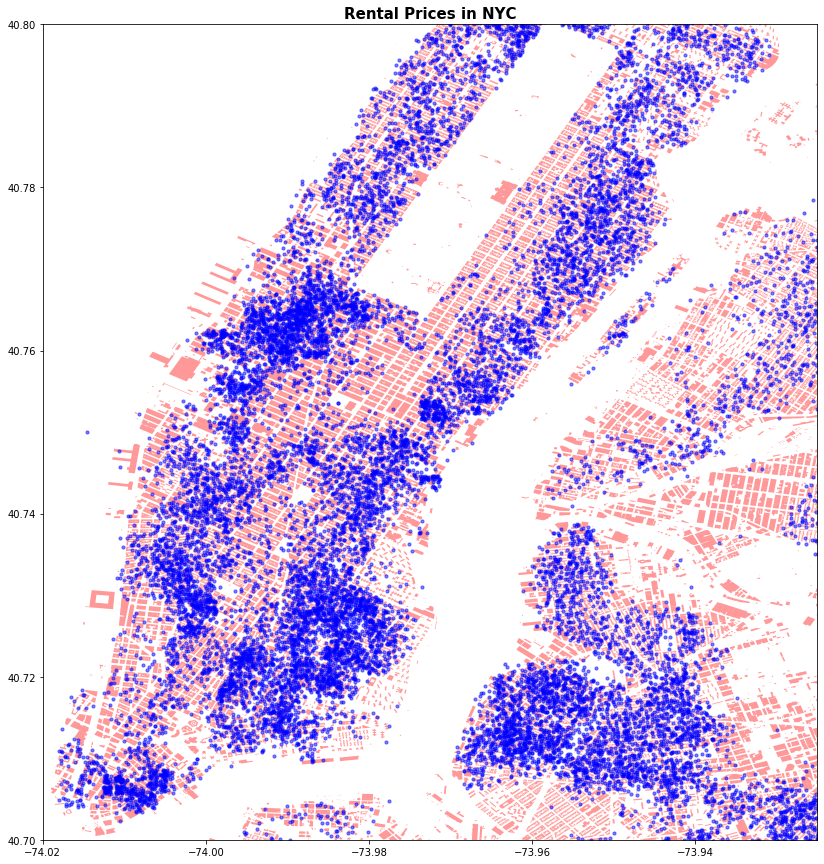

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='red')
geo_df = GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
geo_df.plot(column='price', ax=ax,alpha=0.5, marker='o', color='blue', legend=True,markersize=10)

plt.title('Rental Prices in NYC', fontsize=15,fontweight='bold')
plt.xlim(-74.02,-73.925)
plt.ylim(40.7, 40.8)
plt.show()

In [7]:
geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34226 entries, 0 to 34225
Data columns (total 17 columns):
id                                34226 non-null int64
name                              34214 non-null object
host_id                           34226 non-null int64
host_name                         34213 non-null object
neighbourhood_group               34226 non-null object
neighbourhood                     34226 non-null object
latitude                          34226 non-null float64
longitude                         34226 non-null float64
room_type                         34226 non-null object
price                             34226 non-null int64
minimum_nights                    34226 non-null int64
number_of_reviews                 34226 non-null int64
last_review                       27244 non-null object
reviews_per_month                 27244 non-null float64
calculated_host_listings_count    34226 non-null int64
availability_365                  34226 non-nu

In [19]:
# determine the number of missing entries in each column
df.isnull().sum()[df.isnull().sum() > 0]

name                   12
host_name              13
last_review          6982
reviews_per_month    6982
dtype: int64

In [34]:
df_cat = df.select_dtypes(include = 'object')
df_num = df.select_dtypes(include = 'int64')
df_float = df.select_dtypes(include = 'float64')

df.update(df[df_cat.columns].fillna('na'))
df.update(df[df_num.columns].fillna(0))
df.update(df[df_float.columns].fillna(0.0))

df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [3]:
#for categorical variables:

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [4]:
df_cat = df.select_dtypes(include = 'object')
corr_map = {}

for i in df_cat.columns:
    data = df[i]
    if (correlation_ratio(data, df.price) > 0):
        corr_map[i] = correlation_ratio(data, df.price)

print(corr_map)

{'name': 0.9989991883925328, 'host_name': 0.5349723803813795, 'neighbourhood_group': 0.16525900101094534, 'neighbourhood': 0.2647906688783673, 'room_type': 0.25605451985797223, 'last_review': 0.24711392657852516}


In [8]:
#for numerical variables
import pprint
corr = df.corr()
corr_list = corr['price'].sort_values(ascending = False)
for i in corr_list.index:
    corr_map[i] = corr_list.get(i)
    
#pretty = pprint.PrettyPrinter(width=30)
#pretty.pprint(corr_map)

corr_df = pd.DataFrame(corr_map.items(), columns=['price', 'corr'])
corr_df = corr_df.set_index('price')
corr_df

,corr
price,
name,0.998999
host_name,0.534972
neighbourhood_group,0.165259
neighbourhood,0.264791
room_type,0.256055
last_review,0.247114
price,1.000000
availability_365,0.083439
calculated_host_listings_count,0.053688


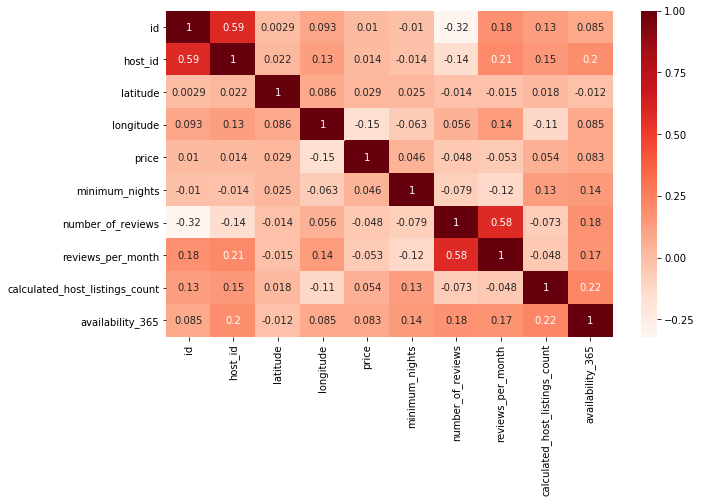

In [29]:
plt.figure(figsize = (10,6))
sns.heatmap(corr, annot=True,cmap=plt.cm.Reds)

In [9]:
#Correlation with output variable
cor_target = abs(corr_df['corr'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

price
name         0.998999
host_name    0.534972
price        1.000000
Name: corr, dtype: float64

In [21]:
# Create correlation matrix
corr_matrix = corr.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]
print(to_drop)
to_drop.extend(['name', 'host_id', 'host_name'])
print(to_drop)

new_df = df.drop(df[to_drop], axis=1)
new_df.head()

['host_id', 'reviews_per_month']
['host_id', 'reviews_per_month', 'name', 'host_id', 'host_name']


,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365
0,5728806,Manhattan,Nolita,40.72217,-73.99481,Private room,120,7,3,2015-09-01,3,0
1,2243769,Manhattan,Upper West Side,40.80020,-73.96045,Entire home/apt,1500,1,0,NaN,1,0
2,35515415,Queens,East Elmhurst,40.75558,-73.89316,Entire home/apt,200,2,4,2019-07-05,1,365
3,36202006,Staten Island,Concord,40.60110,-74.07830,Shared room,30,2,0,NaN,4,82
4,3780951,Manhattan,Harlem,40.81022,-73.94266,Shared room,115,1,16,2019-05-26,1,365


NameError: name 'to_drop' is not defined

In [12]:
new_df.nunique()

id                                34226
neighbourhood_group                   5
neighbourhood                       217
latitude                          16414
longitude                         12892
room_type                             3
price                               621
minimum_nights                       91
number_of_reviews                   367
last_review                        1671
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [35]:
import statsmodels.api as sm
X = df_num.drop('price',1)   #Feature Matrix
y = df.price          #Target Variable
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['id', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']


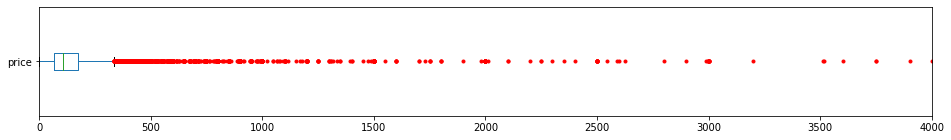

In [13]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
new_df['price'].plot(kind='box', xlim=(0, 4000), vert=False, flierprops=red_square, figsize=(16,2));

In [114]:
new_df.price.describe()

count    34226.000000
mean       153.480979
std        243.312608
min          0.000000
25%         69.000000
50%        107.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [14]:
new_df[new_df.price <= 2000].price.describe()

count    34161.000000
mean       145.864934
std        140.307300
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max       2000.000000
Name: price, dtype: float64

In [15]:
new_df.drop(new_df[ (new_df.price > 2000) | (new_df.price == 0) ].index, axis=0, inplace=True)

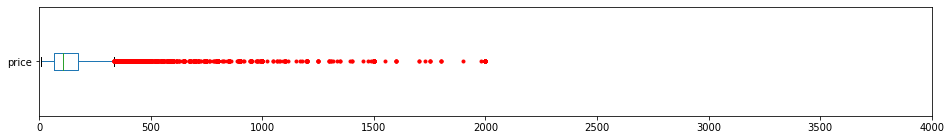

In [16]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
new_df['price'].plot(kind='box', xlim=(0, 4000), vert=False, flierprops=red_square, figsize=(16,2));

In [130]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34152 entries, 0 to 34225
Data columns (total 12 columns):
id                                34152 non-null int64
neighbourhood_group               34152 non-null object
neighbourhood                     34152 non-null object
latitude                          34152 non-null float64
longitude                         34152 non-null float64
room_type                         34152 non-null object
price                             34152 non-null int64
minimum_nights                    34152 non-null int64
number_of_reviews                 34152 non-null int64
last_review                       34152 non-null object
calculated_host_listings_count    34152 non-null int64
availability_365                  34152 non-null int64
dtypes: float64(2), int64(6), object(4)
memory usage: 3.4+ MB


In [17]:
new_df.isna().sum()

id                                   0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       6939
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [18]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34152 entries, 0 to 34225
Data columns (total 12 columns):
id                                34152 non-null int64
neighbourhood_group               34152 non-null object
neighbourhood                     34152 non-null object
latitude                          34152 non-null float64
longitude                         34152 non-null float64
room_type                         34152 non-null object
price                             34152 non-null int64
minimum_nights                    34152 non-null int64
number_of_reviews                 34152 non-null int64
last_review                       27213 non-null object
calculated_host_listings_count    34152 non-null int64
availability_365                  34152 non-null int64
dtypes: float64(2), int64(6), object(4)
memory usage: 3.4+ MB


In [19]:
from geopy.distance import great_circle
def distance_to_mid(lat, lon):
    nyc_centre = (74.0060, 40.7128)
    accommodation = (lat, lon)
    return great_circle(nyc_centre, accommodation).km

ModuleNotFoundError: No module named 'geopy'

In [144]:
print(street_map.centroid.x, street_map.centroid.y)

0         -73.742594
1         -73.921004
2         -73.798330
3         -73.877486
4         -73.803401
5         -73.757175
6         -73.863541
7         -73.840220
8         -73.758774
9         -73.857420
10        -73.774366
11        -73.859741
12        -73.845759
13        -73.838134
14        -73.839495
15        -73.911703
16        -73.778679
17        -73.910205
18        -73.862239
19        -73.843563
20        -73.748190
21        -73.851918
22        -73.857645
23        -73.813508
24        -73.770513
25        -73.861179
26        -73.862529
27        -73.765123
28        -73.800049
29        -73.747587
             ...    
1082319   -73.807955
1082320   -73.809181
1082321   -73.819425
1082322   -73.858401
1082323   -73.850697
1082324   -73.951672
1082325   -74.168683
1082326   -74.168820
1082327   -73.951329
1082328   -73.987354
1082329   -73.968162
1082330   -73.924845
1082331   -73.924985
1082332   -73.957657
1082333   -73.957546
1082334   -73.957880
1082335   -73

In [138]:
df_raw[['name', 'size']].head(10)

,name,size
0,Large private room in Nolita,NaN
1,Super Bowl New York City Apartment,NaN
2,COZY APT CLOSE TO LGA & JFK AND TRANSPORTATION,NaN
3,Stream-Pressed Paradise (Laundry Room Setup),NaN
4,Charming Harlem apartment,NaN
5,Lower Manhattan Luxury,NaN
6,Spacious Clean Studio Apartment,NaN
7,Bright Luxury Apartment with Amazing View of City,NaN
8,Chelsea Brownstone 3 Bedroom House,3.0
9,Heights Haven,NaN


In [146]:
df_raw.name.nunique()

33669

In [148]:
conda install geopy

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.

Note: you may need to restart the kernel to use updated packages.



PackagesNotFoundError: The following packages are not available from current channels:

  - geopy

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [24]:
new_df = new_df.drop(new_df[['neighbourhood','last_review']], axis=1)
new_df = pd.get_dummies(data=new_df, columns=['room_type', 'neighbourhood_group'])


In [25]:
new_df.head()

,id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,5728806,40.72217,-73.99481,120,7,3,3,0,0,1,0,0,0,1,0,0
1,2243769,40.80020,-73.96045,1500,1,0,1,0,1,0,0,0,0,1,0,0
2,35515415,40.75558,-73.89316,200,2,4,1,365,1,0,0,0,0,0,1,0
3,36202006,40.60110,-74.07830,30,2,0,4,82,0,0,1,0,0,0,0,1
4,3780951,40.81022,-73.94266,115,1,16,1,365,0,0,1,0,0,1,0,0


In [26]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34226 entries, 0 to 34225
Data columns (total 16 columns):
id                                   34226 non-null int64
latitude                             34226 non-null float64
longitude                            34226 non-null float64
price                                34226 non-null int64
minimum_nights                       34226 non-null int64
number_of_reviews                    34226 non-null int64
calculated_host_listings_count       34226 non-null int64
availability_365                     34226 non-null int64
room_type_Entire home/apt            34226 non-null uint8
room_type_Private room               34226 non-null uint8
room_type_Shared room                34226 non-null uint8
neighbourhood_group_Bronx            34226 non-null uint8
neighbourhood_group_Brooklyn         34226 non-null uint8
neighbourhood_group_Manhattan        34226 non-null uint8
neighbourhood_group_Queens           34226 non-null uint8
neighbourhood_gro

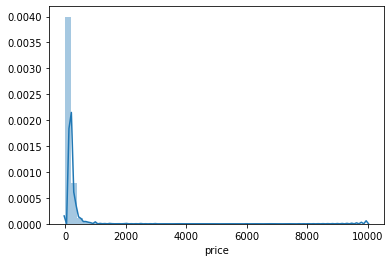

In [28]:
sns.distplot(new_df.price)

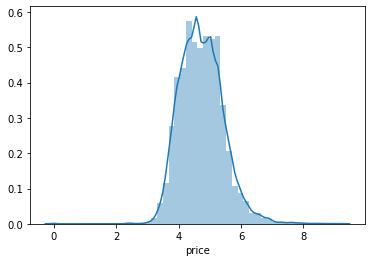

In [29]:
new_df['price'] = np.log1p(new_df.price)
sns.distplot(new_df.price)

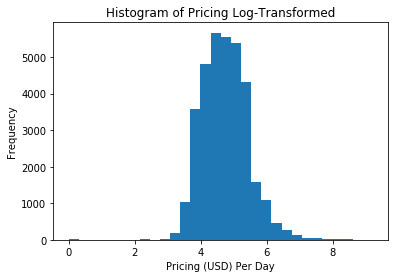

In [31]:
# visualize distribution of price (target variable)
plt.hist(new_df['price'], bins=30)
plt.title("Histogram of Pricing Log-Transformed")
plt.xlabel("Pricing (USD) Per Day")
plt.ylabel("Frequency")
plt.show()